# Argo Winternship 2018 
## Using CustomVision to predict whether my Google Drive Image files have traffic signs
### Written by Duke Yang & Amber Chen

In [170]:
__author = [
    'sunghoonyang'
    , 'Amberchen724'
]
__doc__ = """
TODO:
1. Add more Regulatory Sign. Regulatory Sign seems to be underestimated by the model, probably due to its small training size.
2. Answer and Expand on Descriptive Statistic Section
"""

## Table Of Contents:
* [Dealing with the Prediction Response JSON](#ETL_spec)
* [Descriptive Analytics](#desc)
    * [Number of intersections per neighborhood](#int_per_nbh)
    * [Number of hits per neighborhood](#hit_per_nbh)
    * [Hits per intersection per neighborhood](#hit_per_int_per_nbh)
    * [Questions To Be answered as of Jan 15, 2019](#desc_analytics_questions)


In [139]:
import urllib.request as request
import json
from IPython.display import Image
import pandas as pd
import random
import os
from os import listdir
from os.path import isfile, join
from urllib.error import HTTPError
from time import sleep
import numpy as np
from datetime import datetime
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.ioff()
import gc

%matplotlib inline

In [4]:
"""
Endpoint Instruction
Set Prediction-Key Header to : 369236c7cc65422eba9d40ab87b44295
Set Content-Type Header to : application/octet-stream
Set Body to : <image file>
"""
__PRED_URL__ = r"https://southcentralus.api.cognitive.microsoft.com/customvision/v2.0/Prediction/2ba27441-958e-4e5c-8c04-bab39fef78d9/image?iterationId=1f9ad130-3f6a-475f-bad8-418be34743dd"

### Example Image

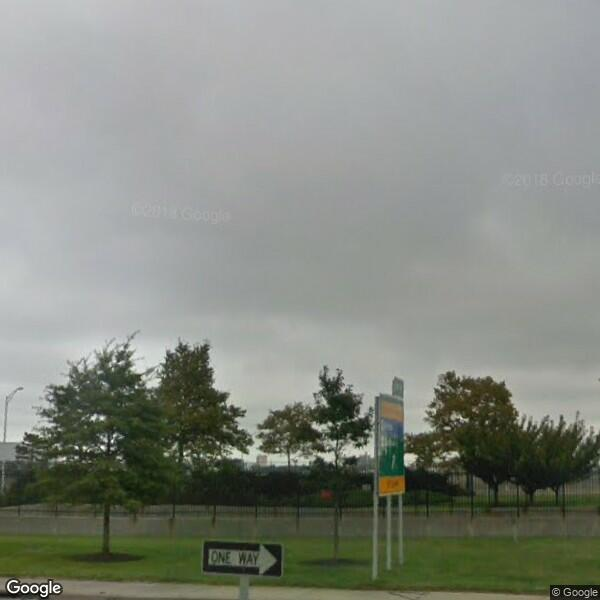

In [5]:
img_file = r"/Users/sunghoonyang/Google Drive/Argo/groundwork-detection/img/neighborhood-images/Airport/40.64467723600012_-73.79764945399995_f30_p10_h0.png"
Image(filename=img_file)

### Request CustomVision prediction with my image file

In [45]:
d = dict(zip(('lat', 'lon', 'fov', 'pitch', 'heading'), img_file.split('/')[-1].split('.png')[0].split('_')))
d.update({'nbh': img_file.split('/')[-2]})
d

{'fov': 'f30',
 'heading': 'h0',
 'lat': '40.64467723600012',
 'lon': '-73.79764945399995',
 'nbh': 'Airport',
 'pitch': 'p10'}

In [71]:
def get_prediction_json(img_file):
    try:
        with open(img_file, 'rb') as img:
            req = request.Request(
                __PRED_URL__
                , headers={
                    'Prediction-Key': r'369236c7cc65422eba9d40ab87b44295'
                    , 'Content-Type': r'application/octet-stream'
                },
                data=img
            )
            res = request.urlopen(req)
            s = res.read().decode('utf8').replace("'", '"')
            j = json.loads(s)
    except Exception as e:
        if isinstance(e, HTTPError) and (e.code == 429):
            print('429 Error - Too Many Request. Retrying after 1 second')
            sleep(5)
            return get_prediction_json(img_file) # retry recursively
        else:
            print(str(e))
            raise e
    else:
        return j

In [69]:
data = get_prediction_json(img_file)
s = json.dumps(data, indent=4, sort_keys=True)
print(s)

{
    "created": "2019-01-15T13:54:04.6259719Z",
    "id": "000f9157-210e-4b1e-b97d-9479e8a4986d",
    "iteration": "1f9ad130-3f6a-475f-bad8-418be34743dd",
    "predictions": [
        {
            "boundingBox": {
                "height": 0.07899034,
                "left": 0.635193,
                "top": 0.6773124,
                "width": 0.0409085155
            },
            "probability": 0.146838427,
            "tagId": "ddf32821-1370-40e1-aead-fbd578bab2ca",
            "tagName": "Guide Sign"
        },
        {
            "boundingBox": {
                "height": 0.0525411963,
                "left": 0.6374146,
                "top": 0.773568034,
                "width": 0.0351688862
            },
            "probability": 0.169035986,
            "tagId": "ddf32821-1370-40e1-aead-fbd578bab2ca",
            "tagName": "Guide Sign"
        },
        {
            "boundingBox": {
                "height": 0.05907184,
                "left": 0.3383056,
              

#### count of prediction results

In [8]:
for pred in data['predictions']:
    tag, prob = pred['tagName'], pred['probability']
    print(tag, prob)

Guide Sign 0.146838427
Guide Sign 0.169035986
Guide Sign 0.0150631927
Info Sign 0.5835459
Warning Sign 0.110808522


<a class="anchor" id="ETL_spec"></a>
### A crude way of dealing with the Prediction Response JSON is as follows:
We count tags (Warning Sign, Info Sign, Guide Sign, Regulatory Sign)whose associated probability is greater than 0.5 with respect to the neighborhood. We will not filter them using boundingBox.

Methodology:
1. We randomly draw 10000 images from neighborhood-images
2. We predict whether the image has a traffic sign with CustomVision prediction request. We count the predictions with probability >0.5 as a *hit* for the particular tag.
3. count total images predicted and positive(>0.5) predictions for each of the tags.

Constraints:
1. we have 10000 predictions per day(?)
    

### 1. RANDOM SELECTION OF IMAGES

In [23]:
__NEIGHBORHOOD_IMG_DIR__ = r"/Users/sunghoonyang/Google Drive/Argo/groundwork-detection/img/neighborhood-images"

__NEIGHBORHOODS__ = [
    f for f in listdir(__NEIGHBORHOOD_IMG_DIR__) \
    if not f.startswith('Icon')
]
# _nbs = [r"Bedford", r"DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill", r"Midtown-Midtown South"]

In [24]:
img_paths = []

for nb in __NEIGHBORHOODS__:
    _nb_path = os.path.join(__NEIGHBORHOOD_IMG_DIR__, nb)
    img_paths.extend([os.path.join(_nb_path, f) for f in listdir(
            _nb_path
        ) if not f.startswith('Icon')
    ])

In [56]:
print('There are', len(img_paths), 'images. First 10 images:')

img_paths[:10]

There are 15425 images. First 10 images:


['/Users/sunghoonyang/Google Drive/Argo/groundwork-detection/img/neighborhood-images/Westchester-Unionport/40.83435548700015_-73.85016535899996_f30_p10_h240.png',
 '/Users/sunghoonyang/Google Drive/Argo/groundwork-detection/img/neighborhood-images/Westchester-Unionport/40.83435548700015_-73.85016535899996_f90_p10_h60.png',
 '/Users/sunghoonyang/Google Drive/Argo/groundwork-detection/img/neighborhood-images/Westchester-Unionport/40.83936455600008_-73.84156266899998_f30_p10_h300.png',
 '/Users/sunghoonyang/Google Drive/Argo/groundwork-detection/img/neighborhood-images/Westchester-Unionport/40.83435548700015_-73.85016535899996_f90_p10_h0.png',
 '/Users/sunghoonyang/Google Drive/Argo/groundwork-detection/img/neighborhood-images/Westchester-Unionport/40.831016712000064_-73.85225362099999_f90_p10_h0.png',
 '/Users/sunghoonyang/Google Drive/Argo/groundwork-detection/img/neighborhood-images/Westchester-Unionport/40.82810554300016_-73.84563298299997_f30_p10_h0.png',
 '/Users/sunghoonyang/Google

## What we Need to collect from this
* Neighborhood Name
* Coordinates
* f, p, h values
* count of prediction results

In [47]:
def get_img_meta_info(img_file):
    lat, lon, fov, pitch, heading = img_file.split('/')[-1].split('.png')[0].split('_')
    fov = fov[1:];pitch = pitch[1:];heading = heading[1:]
    lat, lon, fov, pitch, heading = float(lat), float(lon), int(fov), int(pitch), int(heading)
    nbh = img_file.split('/')[-2]
    return lat, lon, fov, pitch, heading, nbh

In [75]:
RES = []

for _img in random.sample(img_paths, 320): # CustomVision Limit
    lat, lon, fov, pitch, heading, nbh = get_img_meta_info(_img)
    _data = get_prediction_json(_img)
    for pred in _data['predictions']:
        tag, prob = pred['tagName'], pred['probability']
        RES.extend((lat, lon, fov, nbh, tag, prob, pitch, heading)
RES[:10]

429 Error - Too Many Request. Retrying after 1 second


[40.76149779300016,
 -73.73408333499998,
 30,
 'Douglas Manor-Douglaston-Little Neck',
 'Info Sign',
 0.0217059851,
 10,
 300,
 40.62787228000002,
 -73.98480399899995]

In [83]:
# make the list into an array
_raw = np.array(RES).reshape(len(RES) // 8, 8)

In [85]:
prediction20190115 = pd.DataFrame(
    data=_raw
    , columns=['latitude', 'longitude', 'fov', 'neighborhood', 'sign_type', 'probability', 'pitch', 'heading']
)
prediction20190115.head()

,latitude,longitude,fov,neighborhood,sign_type,probability,pitch,heading
0,40.76149779300016,-73.73408333499998,30,Douglas Manor-Douglaston-Little Neck,Info Sign,0.0217059851,10,300
1,40.62787228000002,-73.98480399899995,30,Borough Park,Guide Sign,0.0109875975,10,60
2,40.62787228000002,-73.98480399899995,30,Borough Park,Warning Sign,0.8238124,10,60
3,40.67862681500009,-73.91720270799982,30,Stuyvesant Heights,Info Sign,0.7424901,10,300
4,40.67862681500009,-73.91720270799982,30,Stuyvesant Heights,Info Sign,0.01043467,10,300


In [95]:
__OUTPUT_DIR__ = r'/Users/sunghoonyang/Google Drive/Argo/groundwork-detection/prediction'
prediction20190115.to_csv(
    os.path.join(__OUTPUT_DIR__, '_'.join(['prediction', datetime.strftime(datetime.now(), '%Y%m%d.csv')]))
)

<a class="anchor" id="desc"></a>
## Descriptive Analytics

In [143]:
__VIZ_OUTPUT_DIR__ = r'/Users/sunghoonyang/Google Drive/Argo/groundwork-detection/viz'

<a class="anchor" id="int_per_nbh"></a>
### Number of intersections per neighborhood

In [118]:
_raw_shp = gpd.read_file(
            r"/Users/sunghoonyang/Google Drive/Argo/groundwork-detection/intersection_dta/20190114 Neighborhood Intersections/neighborhood_intersections.shp"
)

In [122]:
intersection_cnt = _raw_shp.groupby('ntaname').count().rename({'geometry': 'count'}, axis=1)
intersection_cnt.head()

,count
ntaname,
Airport,561
Allerton-Pelham Gardens,151
Annadale-Huguenot-Prince's Bay-Eltingville,791
Arden Heights,242
Astoria,313


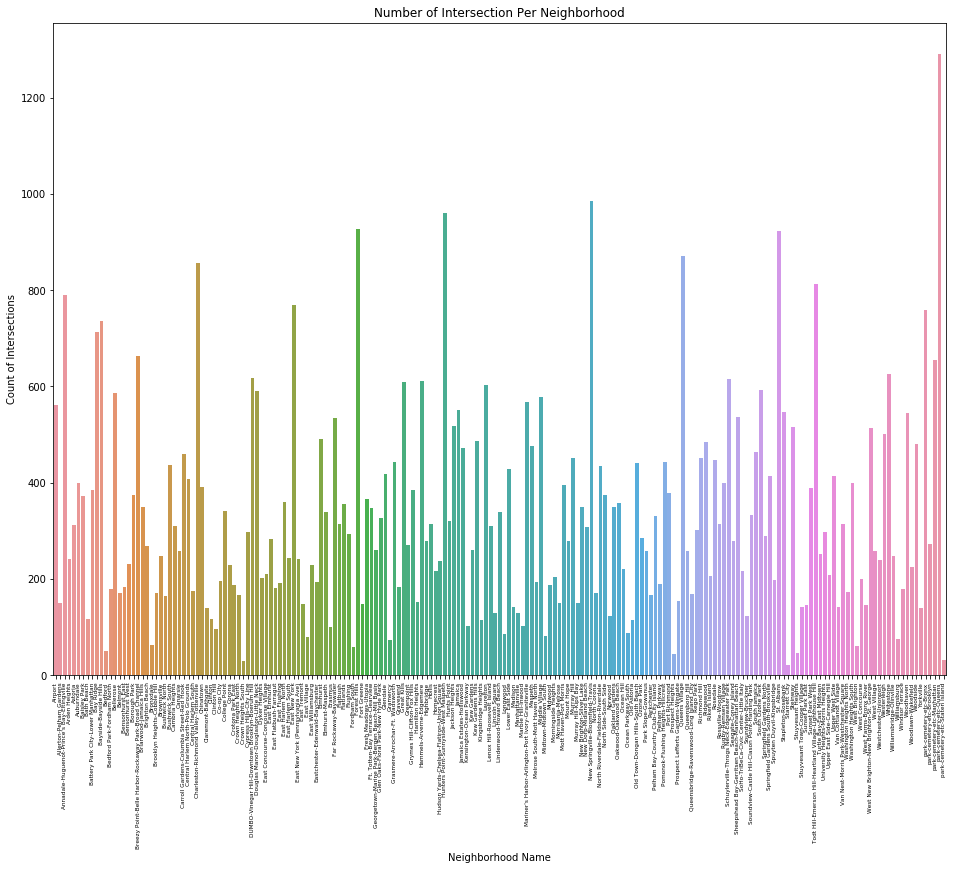

In [158]:
fig = plt.figure(figsize=(16, 12))
g = sns.barplot(intersection_cnt.index, intersection_cnt['count'],) 
g.set_title('Number of Intersection Per Neighborhood')
g.set_xlabel('Neighborhood Name')
g.set_ylabel('Count of Intersections')
g.set_xticklabels(g.get_xticklabels(), rotation=90, fontdict={'fontsize': 'xx-small'})

# save to img file
img_file_path = os.path.join(__VIZ_OUTPUT_DIR__, 'number_of_intersections_per_nb.png')
fig.savefig(img_file_path)

<a class="anchor" id="hit_per_nbh"></a>
### Number of hits per neighborhood

In [101]:
for c, t in {
    'latitude': np.float64
    , 'longitude': np.float64
    , 'fov': np.int32
    , 'pitch': np.int32
    , 'heading': np.int32
    , 'probability': np.float64
}.items():
    lat, lon, fov, pitch, heading = float(lat), float(lon), int(fov), int(pitch), int(heading)
    prediction20190115[c] = prediction20190115[c].astype(t)
prediction20190115.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28050 entries, 0 to 28049
Data columns (total 8 columns):
latitude        28050 non-null float64
longitude       28050 non-null float64
fov             28050 non-null int32
neighborhood    28050 non-null object
sign_type       28050 non-null object
probability     28050 non-null float64
pitch           28050 non-null int32
heading         28050 non-null int32
dtypes: float64(3), int32(3), object(2)
memory usage: 1.4+ MB


In [102]:
prediction20190115.size, prediction20190115[prediction20190115.probability > 0.5].size

(224400, 20616)

In [103]:
20616.0 / 224400

0.0918716577540107

### About 9% of the images have positive prediction of traffic signs 

In [104]:
pos_pred_df = prediction20190115[prediction20190115.probability > 0.5].copy(deep=True)
pos_pred_df.head()

,latitude,longitude,fov,neighborhood,sign_type,probability,pitch,heading
2,40.627872,-73.984804,30,Borough Park,Warning Sign,0.823812,10,60
3,40.678627,-73.917203,30,Stuyvesant Heights,Info Sign,0.742490,10,300
13,40.723086,-73.921275,30,Hunters Point-Sunnyside-West Maspeth,Guide Sign,0.533164,10,0
59,40.855919,-73.917188,90,University Heights-Morris Heights,Regulatory Sign,0.539446,10,240
72,40.734323,-73.922486,30,Hunters Point-Sunnyside-West Maspeth,Info Sign,0.725014,10,0


In [153]:
grped_pos_pred_df = pos_pred_df.groupby('neighborhood').count().rename({'heading': 'count'}, axis=1)
grped_pos_pred_df.head()

,latitude,longitude,fov,sign_type,probability,pitch,count
neighborhood,,,,,,,
Airport,16,16,16,16,16,16,16
Allerton-Pelham Gardens,4,4,4,4,4,4,4
Annadale-Huguenot-Prince's Bay-Eltingville,30,30,30,30,30,30,30
Arden Heights,4,4,4,4,4,4,4
Astoria,25,25,25,25,25,25,25


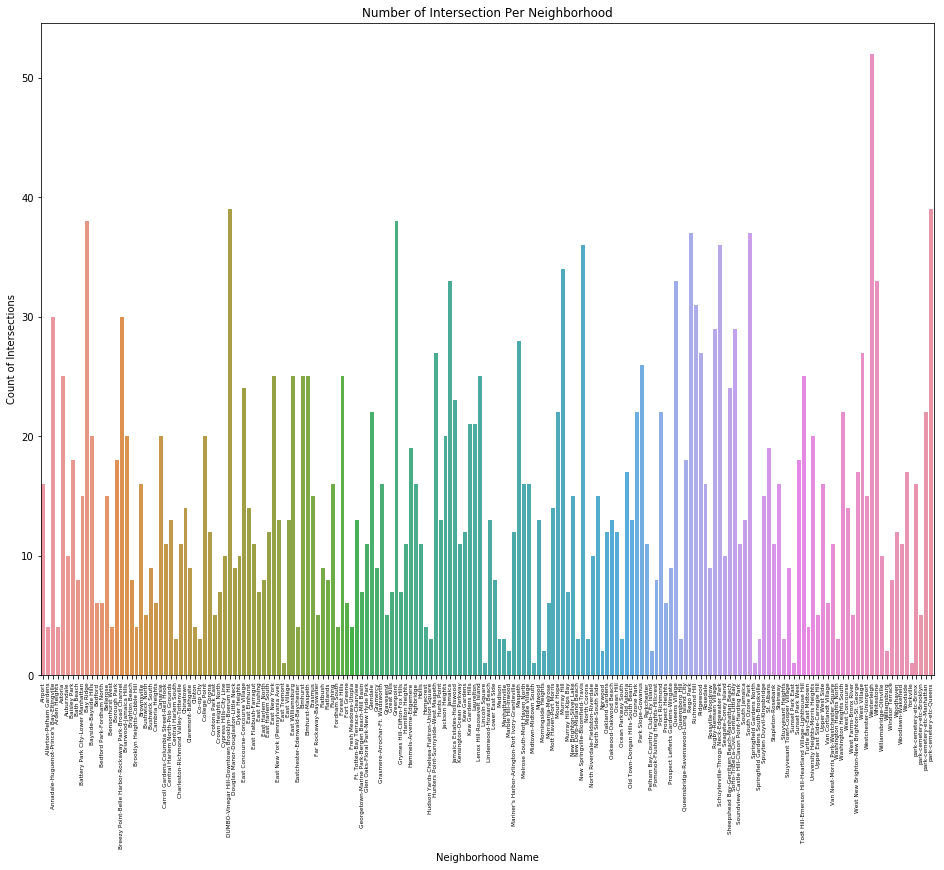

In [157]:
fig = plt.figure(figsize=(16, 12))
g = sns.barplot(grped_pos_pred_df.index, grped_pos_pred_df['count'],) 
g.set_title('Number of Intersection Per Neighborhood')
g.set_xlabel('Neighborhood Name')
g.set_ylabel('Count of Intersections')
g.set_xticklabels(g.get_xticklabels(), rotation=90, fontdict={'fontsize': 'xx-small'})

# save to img file
img_file_path = os.path.join(__VIZ_OUTPUT_DIR__, 'number_of_hits_per_nb.png')
fig.savefig(img_file_path)

<a class="anchor" id="hit_per_int_per_nbh"></a>
### Hits per intersection per neighborhood

Where 
* hit count is $hr$ 
* Number of Intersections is $ni$
* hit per intersection $hpi$ is: $$hpi=\frac{hr}{ni}$$

In [166]:
ratio = grped_pos_pred_df['count'] / intersection_cnt['count']
ratio.head()

Airport                                       0.028520
Allerton-Pelham Gardens                       0.026490
Annadale-Huguenot-Prince's Bay-Eltingville    0.037927
Arden Heights                                 0.016529
Astoria                                       0.079872
Name: count, dtype: float64

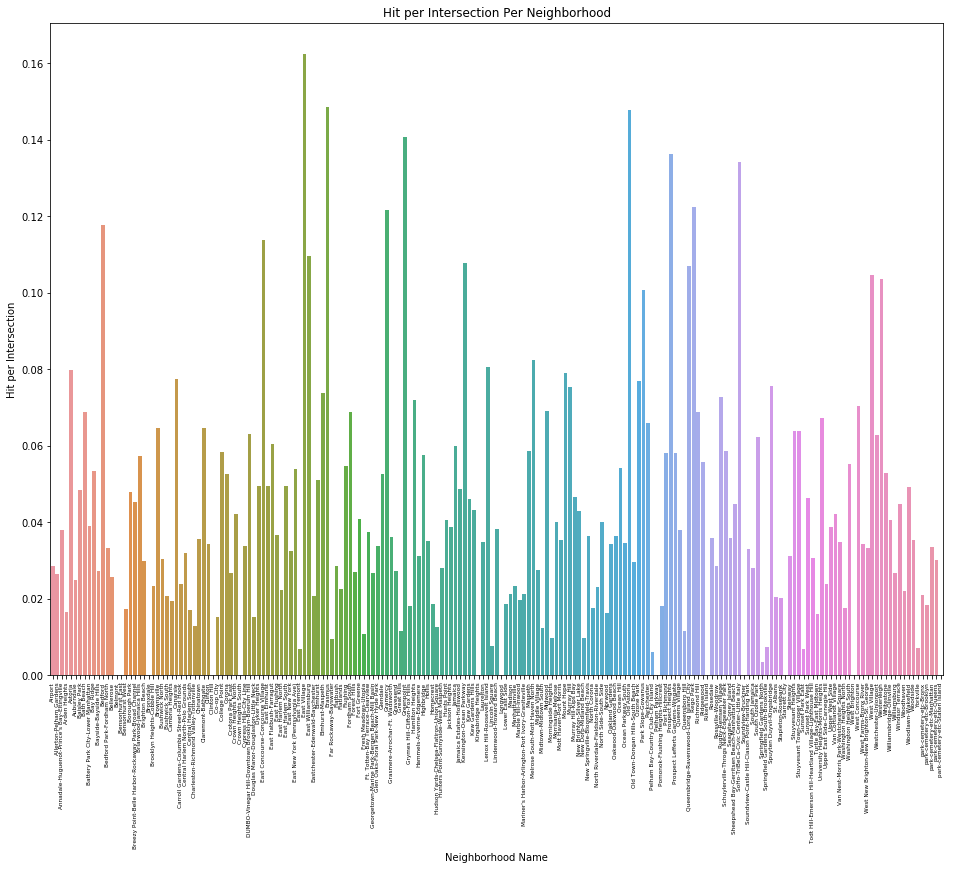

In [168]:
#NUM
fig = plt.figure(figsize=(16, 12))
g = sns.barplot(ratio.index, ratio) 
g.set_title('Hit per Intersection Per Neighborhood')
g.set_xlabel('Neighborhood Name')
g.set_ylabel('Hit per Intersection')
g.set_xticklabels(g.get_xticklabels(), rotation=90, fontdict={'fontsize': 'xx-small'})

# save to img file
img_file_path = os.path.join(__VIZ_OUTPUT_DIR__, 'hit_per_intersections_per_nb.png')
fig.savefig(img_file_path)



<a class="anchor" id="desc_analytics_questions"></a>
#### Questions To Be answered as of Jan 15, 2019:
1. Find Outliers
2. Entire Traffic sign result histogram
1. Random Sampling conserves the distribution of images among neighborhoods
2. Which neighborhoods have more traffic signs in total?
2. Are there clusters in terms of sign_types? This will give us insight about the different classes of distribution of Signs. 


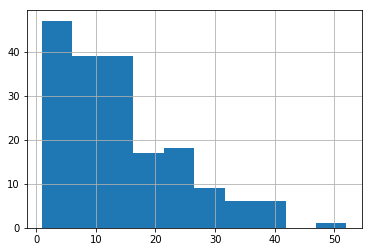

In [114]:
fig = pos_pred_df.groupby(['neighborhood']).count()['latitude'].rename(mapper={'latitude': 'count'}, axis=1).hist()

In [107]:
pos_pred_df.groupby(['neighborhood', 'sign_type']).count()['latitude'].rename(mapper={'latitude': 'count'}, axis=1)

neighborhood                                sign_type      
Airport                                     Guide Sign         10
                                            Info Sign           2
                                            Warning Sign        4
Allerton-Pelham Gardens                     Warning Sign        4
Annadale-Huguenot-Prince's Bay-Eltingville  Guide Sign         14
                                            Info Sign           7
                                            Regulatory Sign     3
                                            Warning Sign        6
Arden Heights                               Regulatory Sign     1
                                            Warning Sign        3
Astoria                                     Guide Sign          8
                                            Info Sign           7
                                            Regulatory Sign     3
                                            Warning Sign        7
Auburndale      

In [169]:
## End of Notebook